# [project1] 탐색적 분석 - COVID19와 지역 감염 추이

#### 분석에 필요한 패키지를 불러옵니다.

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pprint import pprint as pp
from inspect import signature

#### 분석에 필요한 데이터를 클라우드에서 받아옵니다.

In [149]:
df_case = pd.read_csv("./DataScienceforCOVID19/Case.csv")
df_patientInfo = pd.read_csv("./DataScienceforCOVID19/PatientInfo.csv")
df_patientRoute = pd.read_csv("./DataScienceforCOVID19/PatientRoute.csv")
df_timeProvince = pd.read_csv("./DataScienceforCOVID19/TimeProvince.csv")
df_region = pd.read_csv("./DataScienceforCOVID19/Region.csv")

### ===================== 데이터 분석 시작 =====================

### 1. 지역별 누적 확진자 수 파이 그래프
 - 지역별, 6월 30일 기준, 최종 누적확진자 (TimeProvince, 파이그래프)
 - 전체 확진자 수, 지역별 확진자 수, 지역별 비율
 - 우리나라 내 전체 확진자 중 지역별 지분 대한 정보 식별 가능

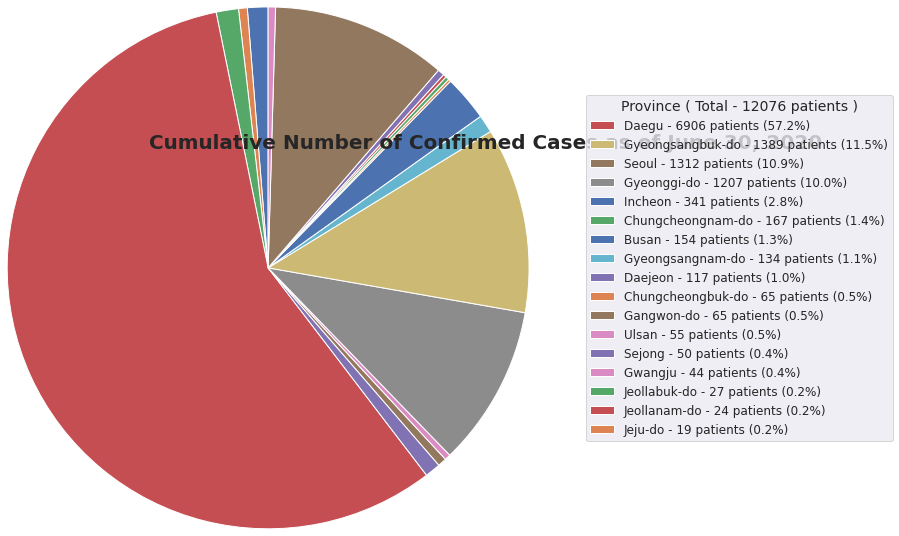

In [150]:
sizes = df_timeProvince.groupby('province')['confirmed'].max() # 지역별 누적확진자 값 중 2020년 6월 30일 기준값들만 가져옴
labels_data = sizes.index # 지역별로 groupby했기 때문에 이때의 index는 지역명이됨
data = sizes.values # 지역별 2020년 6월 30일 기준 누적확진자들의 값이 담김

x = labels_data # 파이 그래프에 들어갈 범례
y = data  # 파이 그래프에서 공간을 차지할 값

porcent = 100.*(y/y.sum()) # 전체 중 해당 값이 차지하는 비율 ( 소숫점으로 나오기 떄문에 100을 곱함 ==> 100.0 * (해당 데이터 / 전체 누적확진자) )

patches, texts = plt.pie(y, startangle=90, radius=3)  # 앵글 90도로 파이 그래프 생성

# 내포 리스트 사용 : x, y, porcent를 한 행으로 만들어서 뽑아 범례 속 내용 후 리스트에 반환
labels =  ['{0} - {1} patients ({2:1.1f}%)'.format(i, k, j) for i,k, j in zip(x, y, porcent)] 
sort_legend = True # 범례 정렬

if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y), key=lambda x: x[2],reverse=True))  # 차지 비율이 높은 순서로 정렬
    
titles = 'Province ( Total - {} patients )'.format(data.sum()) # 범례 제목과 전체 확진자 수 입력을 위해 생성한 문자
    
plt.legend(patches, labels, loc=7, bbox_to_anchor=(3.4, 0.5), fontsize=12, title=titles, title_fontsize=14) # 범례 설정
plt.title("Cumulative Number of Confirmed Cases as of June 30, 2020", weight='bold', size=20, fontdict={'verticalalignment': 'bottom', 'horizontalalignment': 'center'}, position=(1.5,1.8)) # 그래프 제목 설정
plt.show()
# plt.savefig('지역별_6월30일기준_누적확진자_파이그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함

### 2. 날짜별 지역 누적 확진자 수 추이 라인 그래프
 - 시간별, 지역별 누적 확진자의 변화 (TimeProvince, 라인그래프)
 - 지역별 범례, 시간축, 한 그리드 내
 - 시간에 따른 전체지역의 누적확진자 변화 경향

In [151]:
# 분석에 필요한 변수만 추출하여 담습니다.
df_timeProvince_fin = df_timeProvince[['date', 'province', 'confirmed']]

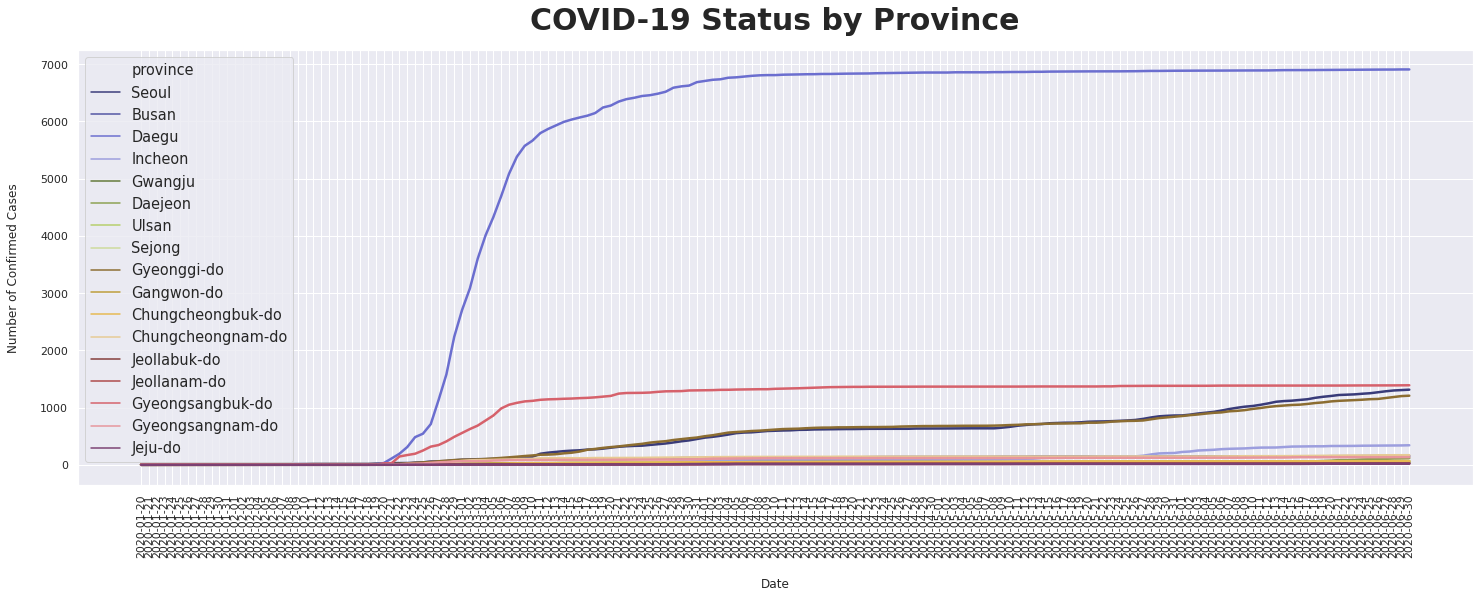

In [152]:
# 라인 그래프를 그립니다.
frame= plt.figure(figsize= (25, 8))
frame= plt.xticks(rotation= 90) # X축 계급을 90도로 돌려서 표시

grid = sns.lineplot(
    x= "date",
    y= "confirmed",
    hue= "province",
    data= df_timeProvince_fin,
    palette= "tab20b",
    linewidth= 2.5
);

# 그래프 레이아웃을 꾸밉니다.
grid.set_title("COVID-19 Status by Province", pad = 20, fontdict={'fontsize':30, 'fontweight':'bold' })
grid.set_ylabel("Number of Confirmed Cases", labelpad=20)
grid.set_xlabel("Date",  labelpad=20)
grid.legend(fontsize=14.5)
sns.set(font_scale = 0)
plt.show()
# plt.savefig('지역별_누적확진자_추이_라인그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함

### 3. 시간에 따른 전국의 누적확진자 변화 경향에 대한 지도 그래프

In [153]:
# 지도 그래프를 그리기 위해서는 folium관련 다른 패키지를 불러와야 합니다.
# 만약 jupyterlab이 설치된 곳에 folium 패키지가 설치되어 있지 않다면 
# pip search folium => pip install folium 해주시기 바랍니다.
import folium 
from folium import plugins
from folium.plugins import HeatMap

In [154]:
df_pro_confrm = df_timeProvince[['date', 'time', 'province', 'confirmed']]
# df_pro_confrm.head(5)

df_region_city = df_region.drop_duplicates('province').reset_index()[['province', 'city','latitude' ,'longitude']]
# df_region_city.head(100)

In [155]:
# 각 월별 마지막일 기준으로 해당 월에 발생한 지역별 누적 확진자 수 정보를 각 데이터 프레임에 담습니다. 
df_pro_01 = df_pro_confrm[df_pro_confrm.date == '2020-01-31'] # 2020-01-31일 지역별 누적 확진자 정보
df_pro_02 = df_pro_confrm[df_pro_confrm.date == '2020-02-29'] # 2020-02-29일 지역별 누적 확진자 정보
df_pro_03 = df_pro_confrm[df_pro_confrm.date == '2020-03-31'] # 2020-03-31일 지역별 누적 확진자 정보
df_pro_04 = df_pro_confrm[df_pro_confrm.date == '2020-04-30'] # 2020-04-30일 지역별 누적 확진자 정보
df_pro_05 = df_pro_confrm[df_pro_confrm.date == '2020-05-31'] # 2020-05-31일 지역별 누적 확진자 정보
df_pro_06 = df_pro_confrm[df_pro_confrm.date == '2020-06-30'] # 2020-06-30일 지역별 누적 확진자 정보

In [156]:
# 현재 우리가 가지고 있는 정보에서는 지역별 시간의 흐름에 따른 누적 확진자수를 보여주는 timeProvince에서 각 지역의 위도, 경도 정보가 없습니다.
# 따라서 지역정보를 담고 있는 resion에서 시청 기준으로 설정된 위도와 경도 값을 사용하여 지도 그래프에 표현하기로 정하였습니다.
# 도시별 지역 정보를 가진 df_region과 각 지역별 누적 확진자 수 정보를 가진 df_pro_월을 'PROVINCE' 컬럼 기준으로 동등 조인합니다.
# pd.merge(기준데이터프레임, 조인할 데이터 프레임, left_on=기준데이터프레임의 조인 기준 컬럼명, right_on=조인할 데이터 프레임의 조인 기준 변수명, how=조인방법)
df_01 = pd.merge(df_pro_01, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')
df_02 = pd.merge(df_pro_02, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')
df_03 = pd.merge(df_pro_03, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')
df_04 = pd.merge(df_pro_04, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')
df_05 = pd.merge(df_pro_05, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')
df_06 = pd.merge(df_pro_06, df_region_city, left_on = 'province', right_on = 'province' , how = 'inner')

In [157]:
# 조인된 데이터프레임에서 지도에 표시할 위도, 경도, 각 지역별 확진자 수를 가져옵니다.
df_01_loc = df_01[['latitude', 'longitude', 'confirmed']]
df_02_loc = df_02[['latitude', 'longitude', 'confirmed']]
df_03_loc = df_03[['latitude', 'longitude', 'confirmed']]
df_04_loc = df_04[['latitude', 'longitude', 'confirmed']]
df_05_loc = df_05[['latitude', 'longitude', 'confirmed']]
df_06_loc = df_06[['latitude', 'longitude', 'confirmed']]

In [158]:
# 지도 그래프에 1월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_01_loc, radius = 36).add_to(m)
m

In [159]:
# 지도 그래프에 2월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_02_loc, radius = 36).add_to(m)
m

In [160]:
# 지도 그래프에 3월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_03_loc, radius = 36).add_to(m)
m

In [161]:
# 지도 그래프에 4월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_04_loc, radius = 36).add_to(m)
m

In [162]:
# 지도 그래프에 5월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_05_loc, radius = 36).add_to(m)
m

In [163]:
# 지도 그래프에 6월 지역 누적 확진자수를 보여줍니다. 
m = folium.Map([36.5, 128], zoom_start=6, control_scale=True, tiles = 'Stamen Toner' )

plugins.Fullscreen(position='topright').add_to(m)
minimap = plugins.MiniMap(toggle_display=True)
m.add_child(minimap)

folium.plugins.HeatMap(df_06_loc, radius = 36).add_to(m)
m

### 4. 1~3월동안 지역별 누적 확진자 변화에 대한 라인 그래프
 - 대구, 경북의 급증 현상의 시점, 변곡점 확인 가능


In [164]:
# 2020년 3월 31일 이전까지의 지역별 누적 확진자 수 정보를 추출합니다.
df_timeProvince_1To3= df_timeProvince_fin[df_timeProvince_fin.date<= "2020-03-31"]

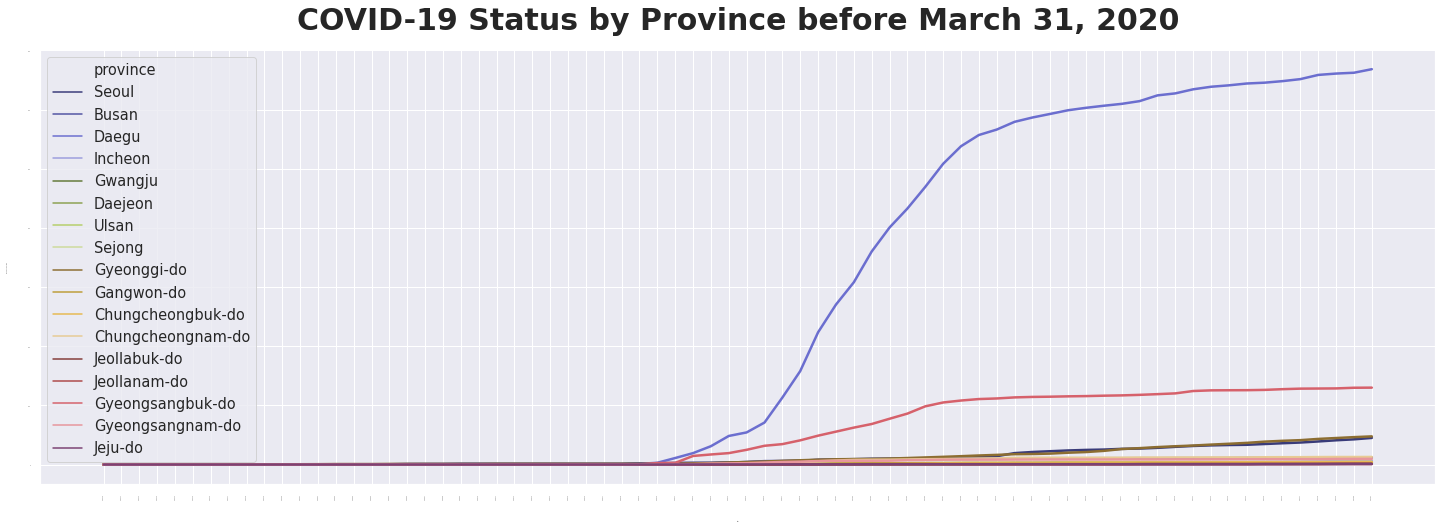

In [165]:
# 라인 그래프를 그립니다.
frame= plt.figure(figsize= (25, 8))
frame= plt.xticks(rotation= 90) # X축 계급을 90도로 돌려서 표시

grid = sns.lineplot(
    x= "date",
    y= "confirmed",
    hue= "province",
    data= df_timeProvince_1To3,
    palette= "tab20b",
    linewidth= 2.5
);

# 그래프 레이아웃을 꾸밉니다.
grid.set_title("COVID-19 Status by Province before March 31, 2020", pad = 20, fontdict={'fontsize':30, 'fontweight':'bold' })
grid.set_ylabel("Number of Confirmed", labelpad=20)
grid.set_xlabel("Date",  labelpad=20)
grid.legend(fontsize=14.5)
sns.set(font_scale = 2)
# plt.savefig('1_to_3월_지역별_누적확진자_추이_라인그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함

### 5-1. 2020년 6월 30일 기준 지역 감염 케이스 별 확진자 수 박스 그래프 
 - 전지역 6월 30일 기준, 감염케이스별 확진자 수 (Case, 박스그래프)
 - Top 지역들의 감염에 영향력이 있는 CASE 여부 확인

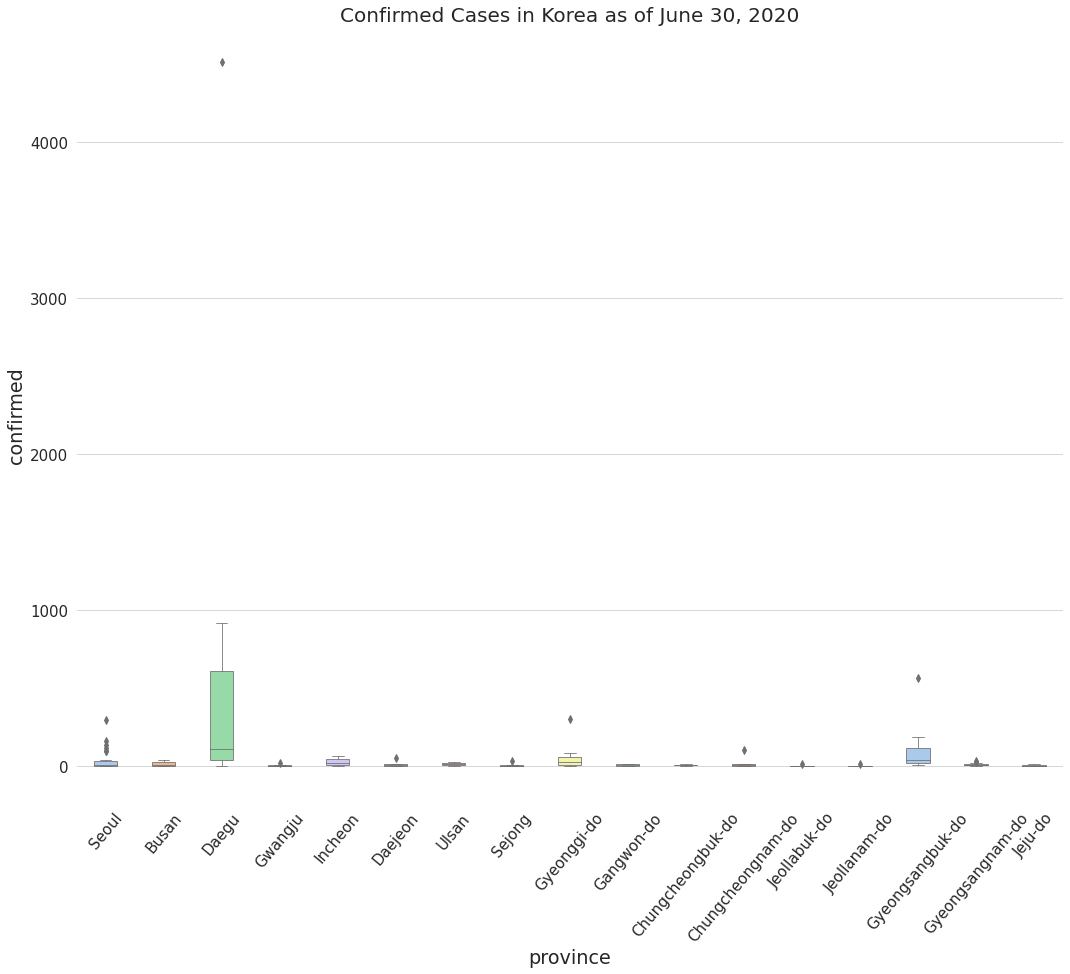

In [166]:
# 지역별 확진자 수 (boxplot)

sns.set(style='whitegrid', font='sans-serif')
sns.set_context("paper", font_scale=2)

color = sns.color_palette("pastel", 14)


frame = plt.figure(figsize = ( 15 , 12 ) ) # Two column paper. Each column is about 3.15 inch wide.
plt.xticks(rotation =50)
plt.tight_layout()  

# splot.yaxis.grid(True, clip_on=False)                                                 
sns.despine(left=True, bottom=True)  

grid = sns.boxplot(x = 'province' , y = 'confirmed' ,data = df_case, palette= color, width=0.4, linewidth = 0.8)
# grid = sns.stripplot(x='province', y='confirmed', data=df_case, color="orange", jitter=0.2, size=2.5)

grid.set_title("Confirmed Cases in Korea as of June 30, 2020", fontsize=20)
grid.tick_params(axis='y', labelsize=15, which = 'both', direction = 'out')
grid.tick_params(axis='x', labelsize=15)
# plt.savefig('2020년6월30일기준_전체_감염케이스별_확진자수_박스그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함

### 5-2. 2020년 6월 30일 기준 서울, 경기, 대구 ,경북 지역 감염 케이스 별 확진자 수 박스 그래프 
 - 전지역 6월 30일 기준, 서울, 경기, 대구 ,경북 지역 감염케이스별 확진자 수 (Case, 박스그래프)
 - Top 지역들의 감염에 영향력이 있는 CASE 여부 확인

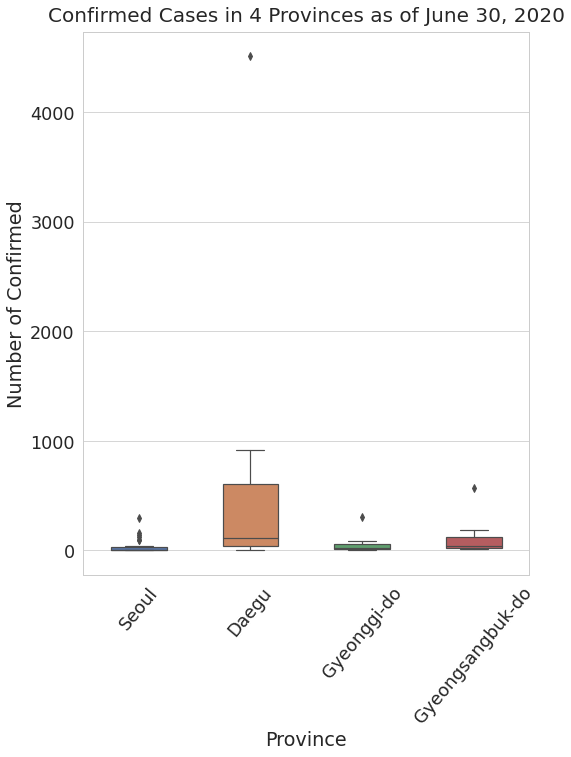

In [167]:
case_sgdg = df_case[df_case.province.isin(['Seoul', 'Gyeonggi-do' , 'Daegu' , 'Gyeongsangbuk-do'])]

# 서울, 경기, 대구. 경북 지역의 케이스별 확진자수 Boxplot (6/30 기준)

frame = plt.figure(figsize = ( 8 , 10 ) )
grid = plt.xticks (rotation = 50)
grid = sns.boxplot(x = 'province' , y = 'confirmed' , width=0.5, data = case_sgdg, palette = sns.color_palette("deep"))
grid.set_title('Confirmed Cases in 4 Provinces as of June 30, 2020', fontsize = 20, pad = 10)
grid.set_xlabel('Province')
grid.set_ylabel('Number of Confirmed')
plt.show()
# plt.savefig('2020년6월30일기준_지역_감염케이스별_확진자수_박스그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함

### 6-1. 2020년 6월 30일 기준 케이스별 감염자 수 TOP5
 - 케이스별 확진자 수 
 - 어떤 CASE가 가장 큰 영향을 끼쳤는지 확인

In [168]:

df_case_group5 = df_case.sort_values(by='confirmed', ascending=False).groupby('infection_case').head(5)
df_case_group5.head(5)
# df_case_group= df_case.groupby("INFECTION_CASE").count()
# df_case_group= pd.DataFrame(df_case_group)
# df_case_group= df_case_group.reset_index()

# labels= list(df_case_group.INFECTION_CASE)
# frame, group = plt.subplots(figsize= (20, 20))
# group.pie(df_case_group.CITY, labels=labels, autopct='%1.1f%%', startangle=90, rotatelabels= True)
# plt.rcParams.update({'font.size': 12})
# plt.show(frame)

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
48,1200001,Daegu,Nam-gu,True,Shincheonji Church,4511,35.84008,128.5667
56,1200009,Daegu,-,False,contact with patient,917,-,-
57,1200010,Daegu,-,False,etc,747,-,-
145,6000001,Gyeongsangbuk-do,from other city,True,Shincheonji Church,566,-,-
109,2000020,Gyeonggi-do,-,False,overseas inflow,305,-,-


### 6-2. 2020년 6월 30일 기준 대구, 경북 케이스별 지역 감염자 수 TOP10 파이그래프
 - 케이스별 확진자 수 (파이그래프)
 - 어떤 CASE가 가장 큰 영향을 끼쳤는지 확인

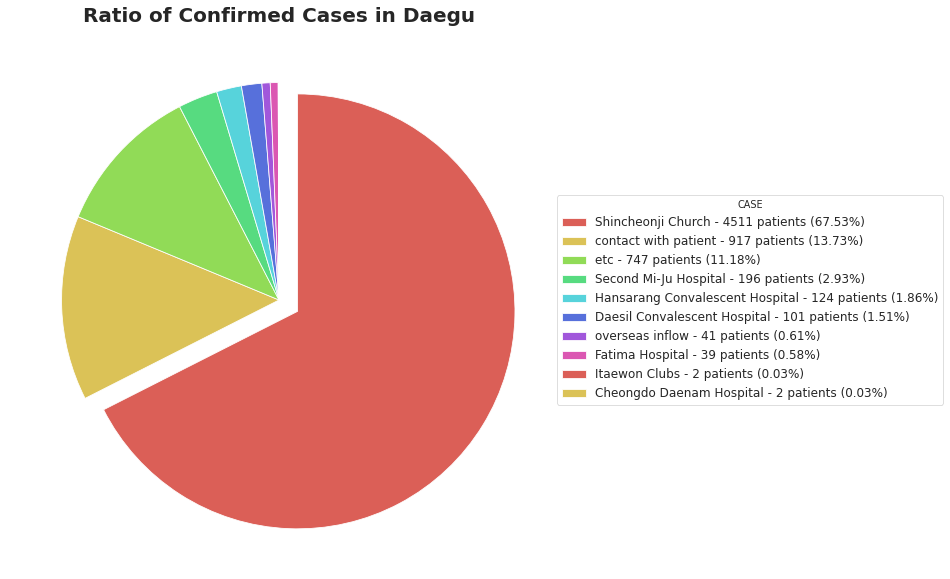

In [169]:
#대구 케이스별 확진자수(내림차순 정렬)
case_DG_group = df_case[df_case.province == 'Daegu'].groupby('infection_case')['confirmed'].sum().sort_values(ascending=False)

labels= list(case_DG_group.index)
data = case_DG_group.values

#확진 케이스: case_gb_group.index

frame , grid = plt.subplots(figsize= (20, 10))

# 전체 중 해당 값이 차지하는 비율 ( 소숫점으로 나오기 떄문에 100을 곱함 ==> 100.0 * (해당 데이터 / 전체 누적확진자) )
porcent = 100.*(data/data.sum()) 

# 내포 리스트 사용 : x, y, porcent를 한 행으로 만들어서 뽑아 범례 속 내용 후 리스트에 반환
labels =  ['{0} - {1} patients ({2:1.2f}%)'.format(i, k, j) for i,k, j in zip(labels, data, porcent)] 

grid.pie(case_DG_group, radius = 1, startangle=90, counterclock = False , colors = sns.color_palette("hls", 8), explode = (0.1,0, 0,0,0,0,0,0,0,0) )
grid.legend(labels, loc = 'center left' , fontsize = 12, bbox_to_anchor=(1, 0.5), title = 'CASE')

grid.set_title('Ratio of Confirmed Cases in Daegu', weight='bold', size=20)

plt.tight_layout
# plt.savefig('Ratio of Confirmed Cases in Daegu' , bbox_inches='tight')
plt.show()

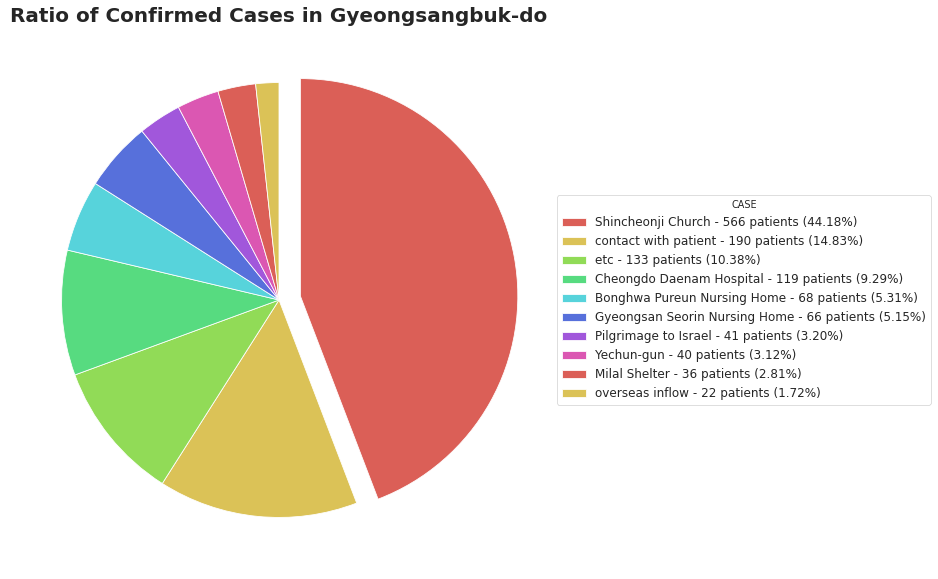

In [170]:
#경북 확진자별 파이그래프

case_GB_group = df_case[df_case.province == 'Gyeongsangbuk-do'].groupby('infection_case')['confirmed'].sum().sort_values(ascending=False).head(10)

labels= list(case_GB_group.index)
data = case_GB_group.values

# 전체 중 해당 값이 차지하는 비율 ( 소숫점으로 나오기 떄문에 100을 곱함 ==> 100.0 * (해당 데이터 / 전체 누적확진자) )
porcent = 100.*(data/data.sum()) 

# 내포 리스트 사용 : x, y, porcent를 한 행으로 만들어서 뽑아 범례 속 내용 후 리스트에 반환
labels =  ['{0} - {1} patients ({2:1.2f}%)'.format(i, k, j) for i,k, j in zip(labels, data, porcent)] 

frame , grid = plt.subplots(figsize= (20, 10))

grid.pie(case_GB_group, radius = 1, startangle=90, counterclock = False , colors = sns.color_palette("hls", 8), explode = (0.1,0,0,0,0,0,0,0,0,0) )

grid.legend(labels, loc = 'center left' , fontsize = 12, bbox_to_anchor=(1, 0.5), title = 'CASE')

grid.set_title('Ratio of Confirmed Cases in Gyeongsangbuk-do', weight='bold', size=20)

plt.tight_layout
# plt.savefig('Ratio of Confirmed Cases in Gyeongsangbuk-do' , bbox_inches='tight')
plt.show()


### 7. 서울, 경기, 대구, 경북 2020년 6월 30일 누적 확진자의 집단 감염 여부 비율 - 바 그래프
 - 지도 그래프로 고급 시각화하여 보여줌
 - 집단 감염/비집단 감염 케이스의 비율 (%)
 - 집단 감염이 얼마나 큰 영향을 끼쳤는지 확인 (1번 인사이트)

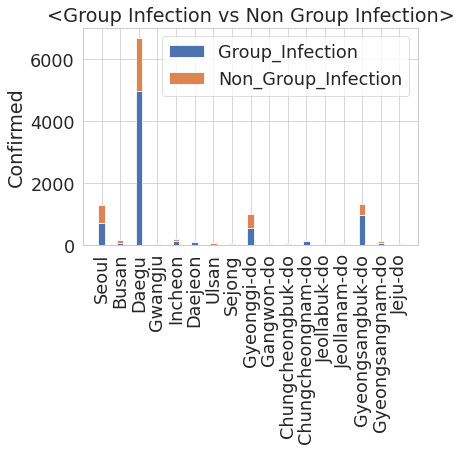

In [171]:
labels = ['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do']
Group_Infection = [720, 71, 4975, 14, 117, 86, 16, 40, 548, 39, 28, 128, 6, 3, 979, 80, 1]
Non_Group_Infection = [560, 85, 1705, 29, 85, 45, 35, 9, 452, 23, 32, 30, 17, 22, 345, 52, 18]


width = 0.35       # the width of the bars: can also be len(x) sequence

fig, grid = plt.subplots()
# grid.set_figure(15,8)
grid.bar(labels, Group_Infection, width,  label='Group_Infection')
grid.bar(labels, Non_Group_Infection, width, bottom=Group_Infection,
       label='Non_Group_Infection')
plt.xticks(rotation=90)
grid.set_ylabel('Confirmed')
grid.set_title('<Group Infection vs Non Group Infection>')
grid.legend()

plt.show()

### 8. 3~6월동안 지역별 누적 확진자 변화에 대한 라인 그래프
 - 대구 경북은 증가율 감소, 서울, 경기는 꾸준히 증가 확인, 변곡점 확인 가능

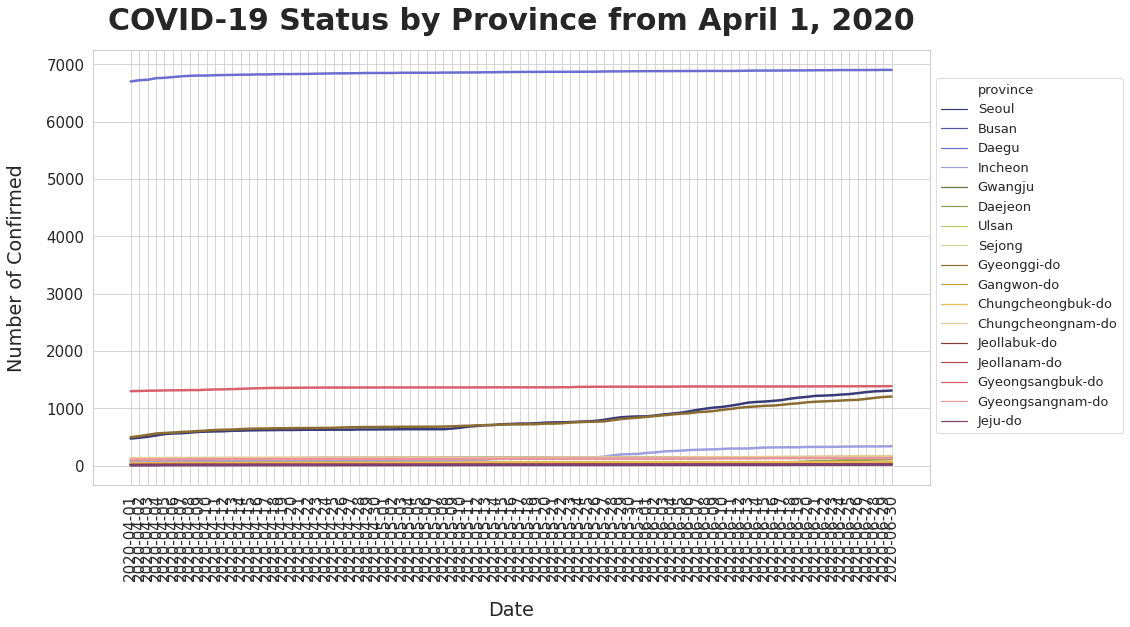

In [172]:
# 2020년 4월 1일 ~ 6월 30일 이전까지의 지역별 누적 확진자 수 정보를 추출합니다.
df_timeProvince_3To6= df_timeProvince_fin[ (df_timeProvince_fin.date >= "2020-04-01") & (df_timeProvince_fin.date <= "2020-06-30")]

frame= plt.figure(figsize= (15, 8))
frame= plt.xticks(rotation= 90, fontsize=15)
frame = plt.yticks(fontsize=15)

grid = sns.lineplot(
    x= "date",
    y= "confirmed",
    hue= "province",
    data= df_timeProvince_3To6,
    palette= "tab20b",
    linewidth= 2.5
);

# 그래프 레이아웃을 꾸밉니다.
grid.set_title("COVID-19 Status by Province from April 1, 2020", pad = 20, fontdict={'fontsize':30, 'fontweight':'bold' })
grid.set_ylabel("Number of Confirmed", labelpad=20)
grid.set_xlabel("Date",  labelpad=20)
grid.legend(fontsize=13, loc=0, bbox_to_anchor=(1.0, 0.95))
sns.set(font_scale = 0)

# plt.savefig('4_to_6월_지역별_누적확진자_추이_라인그래프', bbox_inches='tight') # 그림파일로 그래프를 저장함
plt.show()

### 9. 서울 경기 지역에 4월, 5월, 6월별 감염 케이스 비율 - 파이그래프
 - 지역(서울, 경기), 시점(4/1이후, 5/1이후, 6/1이후), 감염 케이스 비율 (파이그래프)
 - 그리드 row 지역별 나누기, col 시간별 나누기
 - 서울, 경기, 해외 유입 확진자의 영향력 확인

In [173]:
from matplotlib.patches import ConnectionPatch


# 4월 1일 이후 서울, 경기 환자정보

patientInfo_seoul_april = df_patientInfo[
                        (df_patientInfo.province.isin(['Gyeonggi-do','Seoul'])) &
                        (df_patientInfo.confirmed_date >= '2020-04-01') ]


# 5월 1일 이후 서울, 경기 환자정보

patientInfo_seoul_may = df_patientInfo[
                        (df_patientInfo.province.isin(['Gyeonggi-do','Seoul'])) &
                        (df_patientInfo.confirmed_date >= '2020-05-01') ]


# 6월 1일 이후 서울, 경기 환자정보

patientInfo_seoul_june = df_patientInfo[
                        (df_patientInfo.province.isin(['Gyeonggi-do','Seoul'])) &
                        (df_patientInfo.confirmed_date >= '2020-06-01') ]


# 4월 서울/경기 환자 감염사례 별 확진자수 (내림차순)
confirmed_seoul_april = patientInfo_seoul_april.groupby('infection_case')['infection_case'].count().sort_values(ascending=True).tail(10)

# 5월 서울/경기 환자 감염사례 별 확진자수 (내림차순)
confirmed_seoul_may = patientInfo_seoul_may.groupby('infection_case')['infection_case'].count().sort_values(ascending=True).tail(10)

# 6월 서울/경기 환자 감염사례 별 확진자수 (내림차순)
confirmed_seoul_june = patientInfo_seoul_june.groupby('infection_case')['infection_case'].count().sort_values(ascending=True).tail(10)

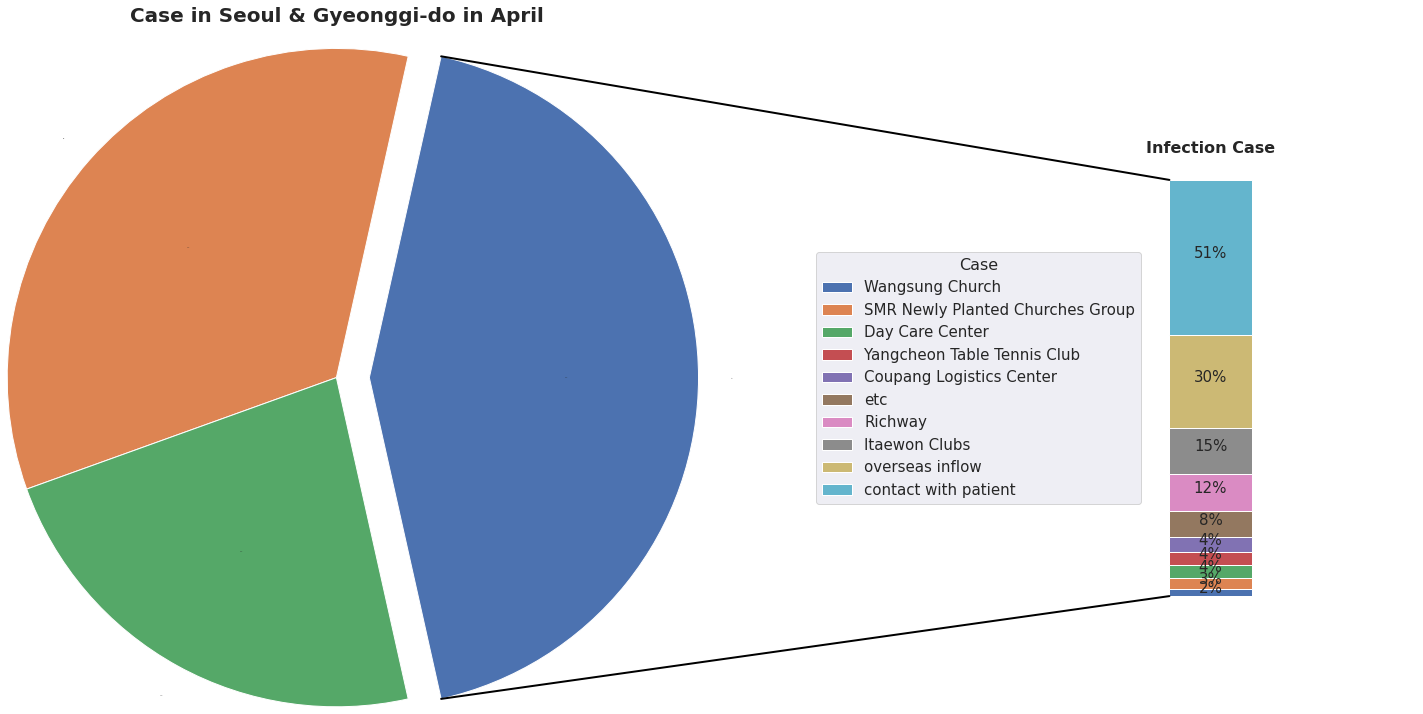

In [174]:
# 4월 서울경기지역 확진자 비율 Bar of Pie


frame = plt.figure(figsize = (20, 10))
pie1 = frame.add_subplot(1, 2, 1)
bar1 = frame.add_subplot(1, 2, 2)


# pie1 chart parameters
ratios = [.43 , .34 , .23]
labels = ['April', 'May', 'June' ]


angle1 = - (360* ratios[0])/2
angle2 = - ((360 * ratios[0])+ (360* ratios[1])/2)
angle3 = - ((360 * ratios[0]) + (360* ratios[1])+ (360* ratios[2])/2)

 
pie1.pie(ratios, autopct='%1.1f%%', startangle= angle1, labels=labels, counterclock = True, radius = 2, explode = (0.2, 0, 0) )
pie1.set_title("Case in Seoul & Gyeonggi-do in April", fontdict={ 'fontsize' : 20, 'fontweight':'bold' } , pad= 150)

# -------------------------------------------------------------- # 


# bar1 chart parameters

xpos = 0
bottom = 0
ratios = confirmed_seoul_april.values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    bar1.bar(xpos, height, width, bottom=bottom, align='center' )
    ypos = bottom + bar1.patches[j].get_height() / 2
    bottom += height
    bar1.text(xpos, ypos, "%d%%" % (bar1.patches[j].get_height() * .1),
             ha='center' , fontsize = 15 )

bar1.set_title('Infection Case' , fontsize = 16 ,  fontdict={'fontweight':'bold'})
bar1.axis('off')
bar1.set_xlim(- 2.5 * width, 2.5 * width)
bar1.legend(confirmed_seoul_april.index, loc = 'center right', bbox_to_anchor=(0.35, 0.5), fontsize = 15, title='Case', title_fontsize=16)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = pie1.patches[0].theta1, pie1.patches[0].theta2
center, r = pie1.patches[0].center, pie1.patches[0].r
bar_height = sum([item.get_height() for item in bar1.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r* np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=bar1.transData,
                      xyB=(x, y), coordsB=pie1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
bar1.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r* np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=bar1.transData,
                      xyB=(x, y), coordsB=pie1.transData)
con.set_color([0, 0, 0])
bar1.add_artist(con)
con.set_linewidth(2)



plt.tight_layout()
# plt.savefig('4월_서울경기지역_확진자_비율_Bar_of_Pie', bbox_inches='tight') # 그림파일로 그래프를 저장함


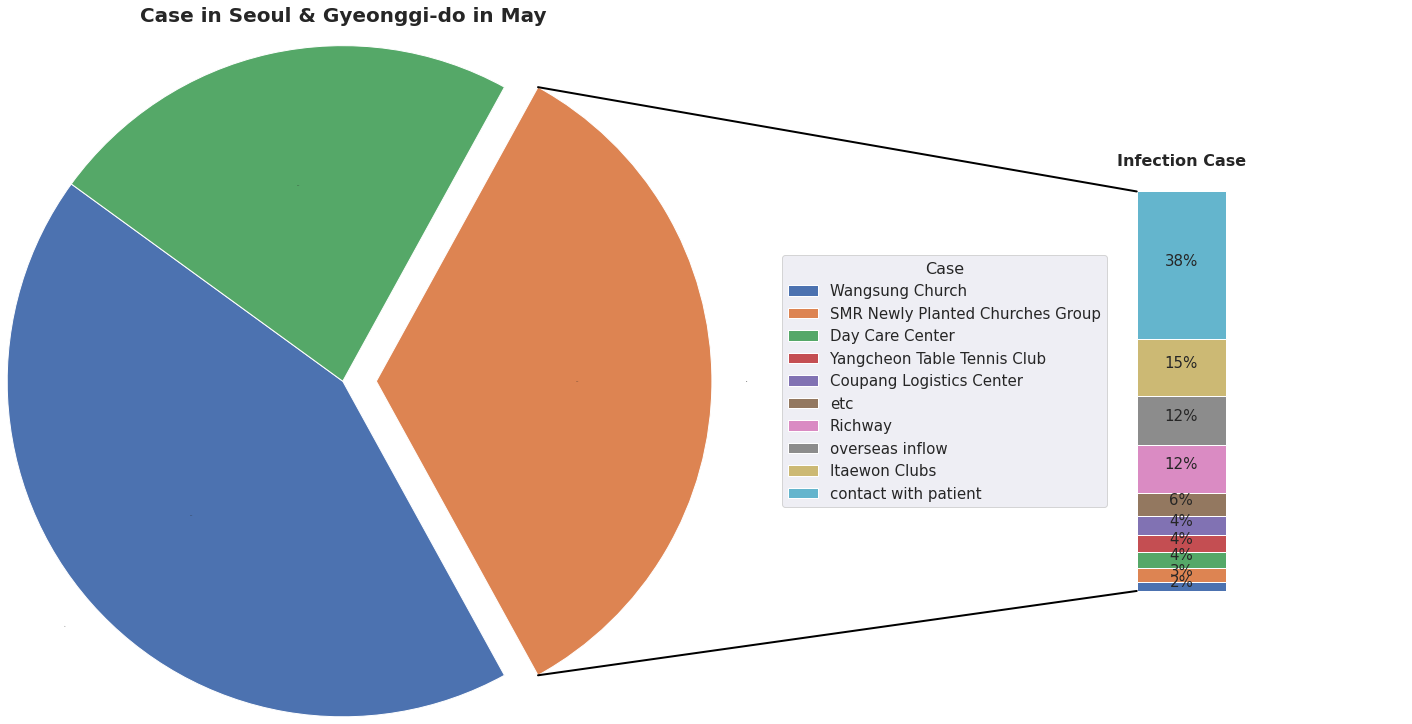

In [176]:
# 5월 서울경기지역 확진자 비율 Bar of Pie 그리기


frame = plt.figure(figsize = (20, 10))
pie2 = frame.add_subplot(1, 2, 1)
bar2 = frame.add_subplot(1, 2, 2)


# pie2 chart parameters
ratios = [.43 , .34 , .23]
labels = ['April', 'May', 'June' ]


angle1 = - (360* ratios[0])/2
angle2 = - ((360 * ratios[0])+ (360* ratios[1])/2)
angle3 = - ((360 * ratios[0]) + (360* ratios[1])+ (360* ratios[2])/2)


# 파이 그리기

pie2.pie(ratios, autopct='%1.1f%%', startangle= angle2, labels=labels, counterclock = True, radius = 2, explode = (0, 0.2, 0) )
pie2.set_title("Case in Seoul & Gyeonggi-do in May", fontdict={ 'fontsize' : 20, 'fontweight':'bold' } , pad= 150)


# bar2 parameters

xpos = 0
bottom = 0
ratios = confirmed_seoul_may.values
width = .2
# colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    bar2.bar(xpos, height, width, bottom=bottom, align='center')
    ypos = bottom + bar2.patches[j].get_height() / 2
    bottom += height
    bar2.text(xpos, ypos, "%d%%" % (bar2.patches[j].get_height() * .1),
             ha='center' , fontsize = 15)

bar2.set_title('Infection Case' ,  fontsize = 16 ,  fontdict={'fontweight':'bold'})
bar2.axis('off')
bar2.set_xlim(- 2.5 * width, 2.5 * width)
bar2.legend(confirmed_seoul_may.index, loc = 'center right', bbox_to_anchor=(0.35, 0.5), fontsize = 15, title='Case', title_fontsize=16)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = pie2.patches[1].theta1, pie2.patches[1].theta2
center, r = pie2.patches[1].center, pie2.patches[1].r
bar_height = sum([item.get_height() for item in bar2.patches])


# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r* np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=bar2.transData,
                      xyB=(x, y), coordsB=pie2.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
bar2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r* np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=bar2.transData,
                      xyB=(x, y), coordsB=pie2.transData)
con.set_color([0, 0, 0])
bar2.add_artist(con)
con.set_linewidth(2)

plt.tight_layout()
# plt.savefig('5월_서울경기지역_확진자_비율_Bar_of_Pie', bbox_inches='tight') # 그림파일로 그래프를 저장함

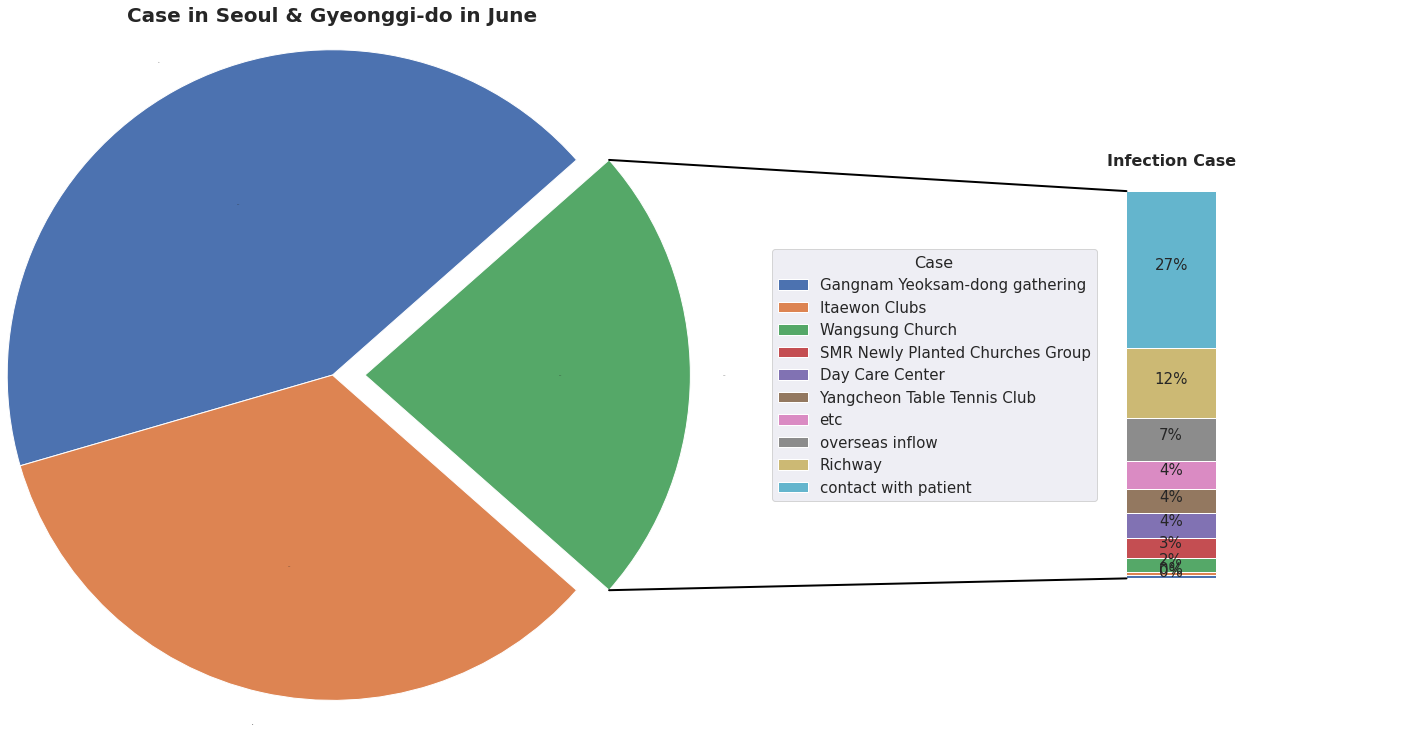

In [177]:
# 6월 서울경기지역 확진자 비율 Bar of Pie 그리기


frame = plt.figure(figsize = (20, 10))
pie3 = frame.add_subplot(1, 2, 1)
bar3 = frame.add_subplot(1, 2, 2)


ratios = [.43 , .34 , .23]
labels = ['April', 'May', 'June' ]

angle1 = - (360* ratios[0])/2
angle2 = - ((360 * ratios[0])+ (360* ratios[1])/2)
angle3 = - ((360 * ratios[0]) + (360* ratios[1])+ (360* ratios[2])/2)


# 파이 그리기

pie3.pie(ratios, autopct='%1.1f%%', startangle= angle3, labels=labels, counterclock = True, radius = 2, explode = (0, 0, 0.2) )
pie3.set_title("Case in Seoul & Gyeonggi-do in June", fontdict={ 'fontsize' : 20, 'fontweight':'bold' } , pad= 150)



# 바 그리기

xpos = 0
bottom = 0
ratios = confirmed_seoul_june.values
width = .2
# colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]


for j in range(len(ratios)):
    height = ratios[j]
    bar3.bar(xpos, height, width, bottom=bottom)
    ypos = bottom + bar3.patches[j].get_height() / 2
    bottom += height
    bar3.text(xpos, ypos, "%d%%" % (bar3.patches[j].get_height() * .1),
             ha='center' , fontsize = 15 )

bar3.set_title('Infection Case' ,  fontsize = 16 ,  fontdict={'fontweight':'bold'})
bar3.axis('off')
bar3.set_xlim(- 2.5 * width, 2.5 * width)
bar3.legend(confirmed_seoul_june.index, loc = 'center right', bbox_to_anchor=(0.35, 0.5), fontsize = 15, title='Case', title_fontsize=16)


# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = pie3.patches[2].theta1, pie3.patches[2].theta2
center, r = pie3.patches[2].center, pie3.patches[2].r
bar_height = sum([item.get_height() for item in bar3.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r* np.sin(np.pi / 180 *  theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=bar3.transData,
                      xyB=(x, y), coordsB=pie3.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
bar3.add_artist(con)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r* np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=bar3.transData,
                      xyB=(x, y), coordsB=pie3.transData)
con.set_color([0, 0, 0])
bar3.add_artist(con)
con.set_linewidth(2)

plt.tight_layout()
# plt.savefig('6월_서울경기지역_확진자_비율_Bar_of_Pie', bbox_inches='tight') # 그림파일로 그래프를 저장함



### 10, 11. 해외 유입 확진자의 주별 발생 빈도
 - 전국, 시간별, 해외 유입 확진자의 주별 발생 빈도
 - 시간축 일자(주별) 표시, 주별 발생 확진자
 - 전체 대비, 해외 유입 확진자의 영향력 확인

In [178]:
from datetime import datetime

# 도보이동형 선별 진료소 시행  (2020-02-26 시행 시작)
# 주요 입국절차 Immigration 정책 시행 : 13-14주
        # 4월 1일 : 14일 자가 격리 정책 시작
        # 4월 13일 : 자가 격리 및 자가 진단 정책 시작 

In [179]:
#final_table.csv파일도 같이 다운 받아서 작업을 해야합니다
df_patient= pd.read_csv("./DataScienceforCOVID19/final_table.csv")

#상단에 df_patient는 정확한 날짜 및 주별 정보가 없어서 그런 정보가 들어 있는 NJ.csv 을 따로 만들었습니다
#NJ.csv라는 파일도 같이 보내드립니다
df_dates= pd.read_csv("./DataScienceforCOVID19/NJ.csv")

In [180]:
#df_patient 데이터에 필요없는 컬럼 삭제
del df_patient['sex']
del df_patient['Unnamed: 0']
del df_patient['latest_confirmed']

#NJ의 데이터와 df_patient 를 patient_id를 기준으로 잡아서 합쳤습니다
dateAdded = pd.merge(df_patient, df_dates, left_on='patient_id', right_on='PATIENT_ID', how='inner')

#필요없는 컬럼 삭제
del dateAdded['CITY']
del dateAdded['PATIENT_ID']
del dateAdded['AGE']

In [181]:
int_cases=dateAdded[(dateAdded.infection_case=='overseas inflow')|(dateAdded.type=='airport')]

del int_cases['patient_id']
del int_cases['infected_by']

In [182]:
# 해외 유입 사례
int_cases_inf= {"province": int_cases.province,
                "infection_case": int_cases.infection_case, 
                "week_number": int_cases.week_number}

int_cases_inf= pd.DataFrame(int_cases_inf)

int_cases_inf= int_cases_inf.dropna(axis= 0)
int_cases_inf= int_cases_inf.groupby(["province", "week_number"]).count()
int_cases_inf= pd.DataFrame(int_cases_inf)
int_cases_inf= int_cases_inf.reset_index()

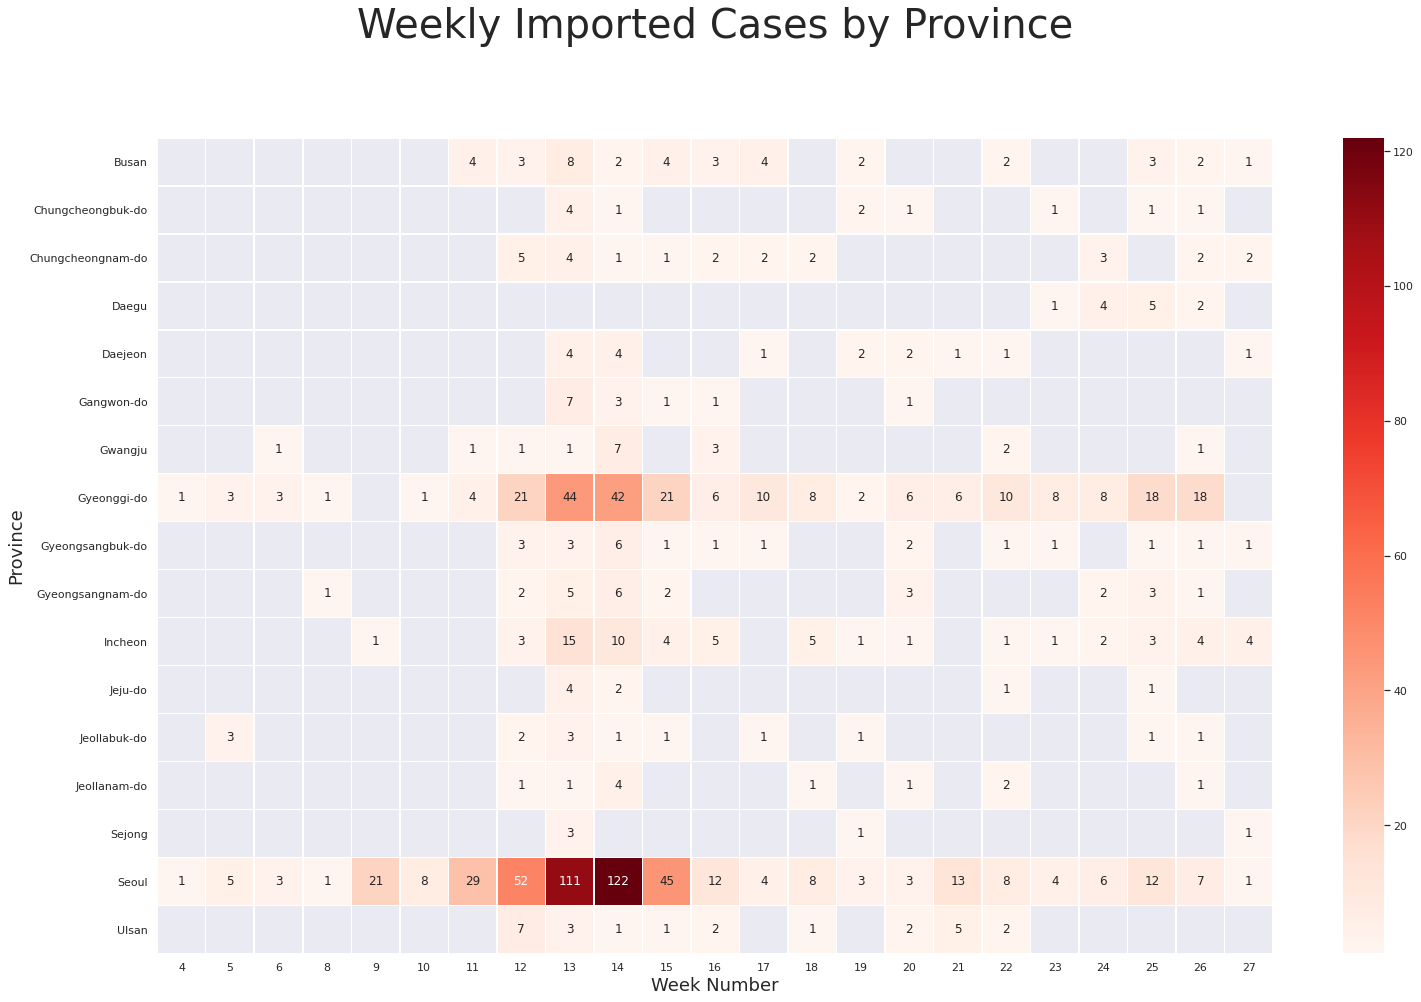

In [186]:
count = int_cases_inf.pivot("province", "week_number", "infection_case")


frame, grid = plt.subplots(figsize= (25, 15))
grid.set_title("Weekly Imported Cases by Province", fontsize=40, pad=100)
sns.heatmap(count, annot= True, linewidths= .5, ax= grid, cmap= "Reds", fmt='g')
sns.set(font_scale= 1)
plt.xlabel('Week Number', fontsize=18)
plt.ylabel('Province', fontsize=18)
plt.show()
# plt.savefig('Weekly_Imported_Cases_by_Province', bbox_inches='tight') # 그림파일로 그래프를 저장함

In [187]:
# 공항 감염 사례
int_cases_typ= {"province": int_cases.province, "type": int_cases.type, "week_number": int_cases.week_number}
int_cases_typ= pd.DataFrame(int_cases_typ)
int_cases_typ= int_cases_typ.dropna(axis= 0)
int_cases_typ= int_cases_typ[int_cases_typ.type== "airport"]

int_cases_typ= int_cases_typ.groupby(["province", "week_number"]).count()
int_cases_typ= pd.DataFrame(int_cases_typ)
int_cases_typ= int_cases_typ.reset_index()

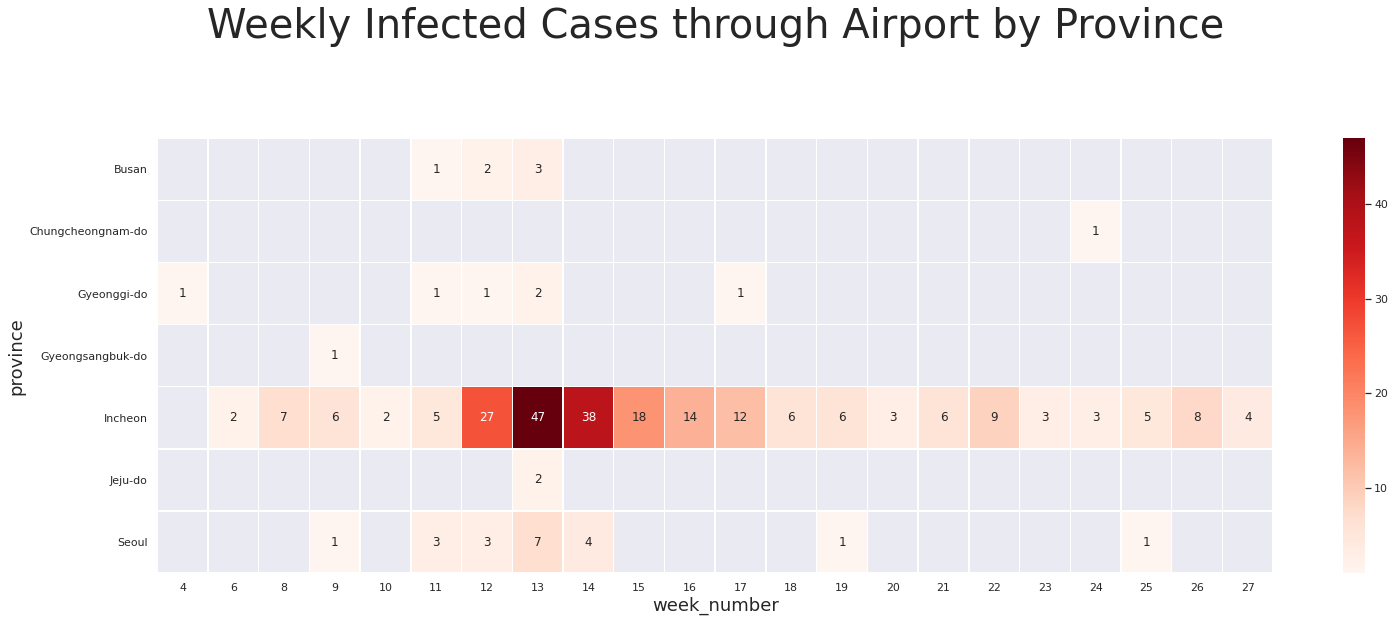

In [189]:
count = int_cases_typ.pivot("province", "week_number", "type")

frame, grid = plt.subplots(figsize= (25, 8))
grid.set_title("Weekly Infected Cases through Airport by Province", fontsize=40, pad=100)
sns.set(font_scale= 1)
plt.xlabel('Week Number', fontsize=18)
plt.ylabel('Province', fontsize=18)
sns.heatmap(count, annot= True, linewidths= .5, ax= grid, cmap= "Reds")
plt.show()
# plt.savefig('Weekly_Infected_Cases_through_Airport_by_rovince', bbox_inches='tight') # 그림파일로 그래프를 저장함_

### 12. 시간에 따른 전국의 누적확진자 변화 경향
 - 전국, 6월 30일 기준, 누적확진자 변화 (PatientInfo, 지도그래프)

In [190]:
index_null= df_patientInfo.contact_number[df_patientInfo.contact_number== "-"].index
df_patient_nn= df_patientInfo.drop(index_null)
# df_patient_nn

df_patient_nn["contact_number"]= pd.to_numeric(df_patient_nn.contact_number)
del df_patient_nn["contact_number"]
# df_patient_nn.info()

df_marge= pd.merge(df_patient_nn, df_region, on= "city")
# pp(type(df_marge))
# df_marge

df_group= df_marge.groupby("city").count()
# pp(type(df_group))
df_group= {"patient_id": df_group.patient_id}
df_group= pd.DataFrame(df_group)

# df_group

df_city= df_marge
df_city= {"city": df_city.city, "latitude": df_city.latitude, "longitude": df_city.longitude}
df_city= pd.DataFrame(df_city)
df_city_nn= df_city.drop_duplicates("city")

# df_city_nn

df_city_nn= pd.merge(df_city_nn, df_group, on= "city")
# df_city_nn

df_city_nn= df_city_nn.reset_index().sort_values("city")
# df_city_nn

df_city_xy= {"latitude": list(df_city_nn.latitude), "longitudeE": list(df_city_nn.longitude), "patient_id": list(df_city_nn.patient_id)}
df_city_xy= pd.DataFrame(df_city_xy)
df_city_xy

df_patient = pd.merge(df_patientInfo[['patient_id','province','city']],
                     df_region[['province','city','latitude','longitude']], 
                     how = 'left', 
                     on = ['province','city'])
regional_count = df_patient[['latitude','longitude']].dropna()
regional_count

,latitude,longitude
0,37.551166,126.849506
1,37.606832,127.092656
2,37.572999,126.979189
3,37.566283,126.901644
4,37.589562,127.016700
...,...,...
5160,33.488936,126.500423
5161,33.488936,126.500423
5162,33.488936,126.500423
5163,33.488936,126.500423


In [191]:
count_map= folium.Map(location= [36, 128], zoom_start= 8, tiles='stamenToner')

folium.plugins.HeatMap(df_city_xy, radius= 30).add_to(count_map)

# for i in list(df_city_nn.index):
#     folium.Circle(
#         location=[df_city_nn.LATITUDE.iloc[i], df_city_nn.LONGITUDE.iloc[i]],
#         radius= 20* int(df_group.PATIENT_ID.iloc[i]),
# #         radius= 1000,
#         color= "#000000",
#         fill= True,
#         fill_color= "#000000",
#         popup= df_group.PATIENT_ID.iloc[i]
#     ).add_to(count_map)
#     pass    # end of for

folium.plugins.Fullscreen(position='topright').add_to(count_map)

minimap = folium.plugins.MiniMap(toggle_display=True)
count_map.add_child(minimap)

folium.plugins.MarkerCluster(regional_count).add_to(count_map)

count_map

In [192]:
df_city_xy

,latitude,longitudeE,patient_id
0,36.568441,128.729551,53
1,37.321863,126.830920,33
2,37.008008,127.279763,4
3,37.394258,126.956752,63
4,36.789844,127.002420,18
...,...,...,...
150,37.410262,126.678309,45
151,34.760421,127.662287,3
152,37.240985,127.178050,104
153,37.532768,126.990021,50


In [193]:
# 결론, 해외유입 확진자도 영향이 있는 것을 확인
# 코로나19 확산의 가장 큰 요인은 집단감염이다.
# 4월 이후 집단감염과 환자와의 접촉이 가장 많은 감염을 일으키고 있음.
# 그러니, 집단이 모일 공간을 피하고, 개인 위생을 철저히 하자.

In [194]:
# 번외
# Public Tranceportation

In [195]:
# PatientInfo.csv는 대구의 정보가 대체로 빠져있음.
# 대구 외의 정보는 누적으로 확인 결과, TimeProince와 동일함을 확인.

In [196]:
# version = 2020.07.11